# Expedia hotel recommendations, kaggle contest

## Data clarifications

**hotel_cluster**
 * They are clusters of similar hotels. These clusters are based on hotels popularity, star rating, user review rating, price, distance from city center, amenities, etc. Hotels can belong to different clusters depending on seasonality (e.g. a hotel can be popular and expensive during summer, and cheap and not very popular during winter).
 * we don't take room types and services into account
 * clustering is also based on distance of a hotel from a center of srch_destination_id. What it means is that clustering assignment of a hotel e.g. in New York can change depending on whether it was clicked/booked from "New York and vicinity" or "Statue of Liberty"
 * Clustering is based on static hotel attributes and dynamic hotels attributes. Two most important dynamic variables are historical (log) price and historical (log) # of transactions. If possible, both of them are taken from the same season as check-in date but previous year.
 * cluster assignments can change. For example, in winter a hotel is cheap and not-popular and will be assigned to cluster A, and in summer the same hotel will become expensive and popular and will be assigned to cluster B. In addition to yearly seasonality, we can observe weekly seasonality as well (hotels are cheaper and not popular in weekdays, and more expensive and popular during weekends).

**orig_destination_distance**
 * Keep in mind that orig_destination_distance is rounded to significant 4 digits after comma, and many destinations are dense with hotels, that's why it's not uncommon to see the same value of orig_destination_distance for different hotels.
 * What's the unit for orig_destination_distance?
 >miles
 
**user_location_country_id, hotel_country_id, srch_destination_id**
 * Do the mappings of user_location_country_id and hotel_country_id resolve to the same country?
 >The underlying country names are the same, but the way these names were hashed is different. It means that you cannot use user_location_country_id and hotel_country_id to infer if a trip was domestic or international.
 * user_location_country is something like (e.g. "UK", "Germany") and from a given user_location_country you can search different srch_destination_id (e.g. "New York", "London")
 * **All categories are constant across all sites**, i.e. "srch_destination_id"'s category 3 is "New York" no matter what are the other attributes
 
**is_booking**
 * is_booking = 1 if a given hotel was booked and is_booking = 0 if a given hotel was clicked (i.e. a user clicked a link to see hotel details on a hotel infosite page). This column is omitted from the holdout data because all events in the holdout data are bookings.

**cnt**
 * Basically, it's the # of clicks on a given hotel inforsite page in the context of a user session. A user session is defined with a 30 min of inactivity. It happens rarely that a user books the same hotel more than once in the same session, hence usually cnt = 1 if is_booking = 1. Intuitively, the higher the cnt the more a user is interested in a given hotel. Again, this column is omitted from the holdout data because all events in the holdout data are bookings.
 
**channel**
 * Basically, it's an info on how a user got to the expedia web page. It can be something like: "Direct", "SEM" (e.g. via Google paid links), "Meta channel" (e.g. via Tripadvisor), etc.
 
**destinations.csv**
 * d1-d149: This is a latent description of hotel reviews that are related to a given search destination. These columns correspond to different facets (e.g. beach, ski, etc.) and values are (log) probabilities that a customer would endorse a hotel in the destination for a specific facet.
 
**user_location_city and its relationship to user_location_country**
 * I thought that any particular city should belong to one country only, but it appears that this is not the case. In fact, in the first million rows of the train.csv there is a city (26750) that appears in 17 different countries. That was the most extreme example but there are 507 cities that have more than one country. About 187 thousand rows of the first million have one of these cities.
 > hashing was done by name only and there are cities with the same name in different countries. What it means is that user_location_city should be used only in the context of corresponding user_location_country/region, and user_location_region should be only used in the context of corresponding user_location_country.
 
## About data leak
> Confirm there is a leak in the data and it has to do with the orig_destination_distance attribute.
Our estimate is this directly affects approx. 1/3 rd of the holdout data.
The contest will continue without any changes. For clarity, we are confirming you can find hotel_clusters for the affected rows by matching rows from the train dataset based on the following columns: user_location_country, user_location_region, user_location_city, hotel_market and orig_destination_distance. However, this will not be 100% accurate because hotels can change cluster assignments (hotels popularity and price have seasonal characteristics).

 * Are you going to continue using effected rows in score calculations or they will be excluded?
 >They won't be excluded.


In [1]:
import csv
import time
from collections import Counter

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn

In [2]:
# just doc
[('date_time', 0),
 ('site_name', 1),
 ('posa_continent', 2),
 ('user_location_country', 3),
 ('user_location_region', 4),
 ('user_location_city', 5),
 ('orig_destination_distance', 6),
 ('user_id', 7),
 ('is_mobile', 8),
 ('is_package', 9),
 ('channel', 10),
 ('srch_ci', 11),
 ('srch_co', 12),
 ('srch_adults_cnt', 13),
 ('srch_children_cnt', 14),
 ('srch_rm_cnt', 15),
 ('srch_destination_id', 16),
 ('srch_destination_type_id', 17),
 ('is_booking', 18),
 ('cnt', 19),
 ('hotel_continent', 20),
 ('hotel_country', 21),
 ('hotel_market', 22),
 ('hotel_cluster', 23)]


def read_trainfile(filename='train.csv'):
    user_ids = Counter()
    hotel_clusters = Counter()
    start = time.time()
    with open(filename, 'rb') as f:
        csv_reader = csv.reader(f)
        csv_reader.next()  # skip header
        # for train checking is everything ok - read first 1M rows
        # for i, row in zip(range(1000000), csv_reader):
        for row in csv_reader:
            user_id = int(row[7])
            hotel_cluster = int(row[23])
            user_ids[user_id] += 1
            hotel_clusters[hotel_cluster] += 1
            
    total = time.time() - start
    print('Total time: %d sec' % total)
    print('Rows per sec: %d' % int(37670293.0 / total))
    
    users_info = pd.Series(user_ids.values(), index=user_ids.keys(), name='user')
    hotels_info = pd.Series(hotel_clusters.values(), index=hotel_clusters.keys(), name='hotel')
    return users_info, hotels_info
           

users_info, hotels_info = read_trainfile('train.csv')

Total time: 165 sec
Rows per sec: 227151


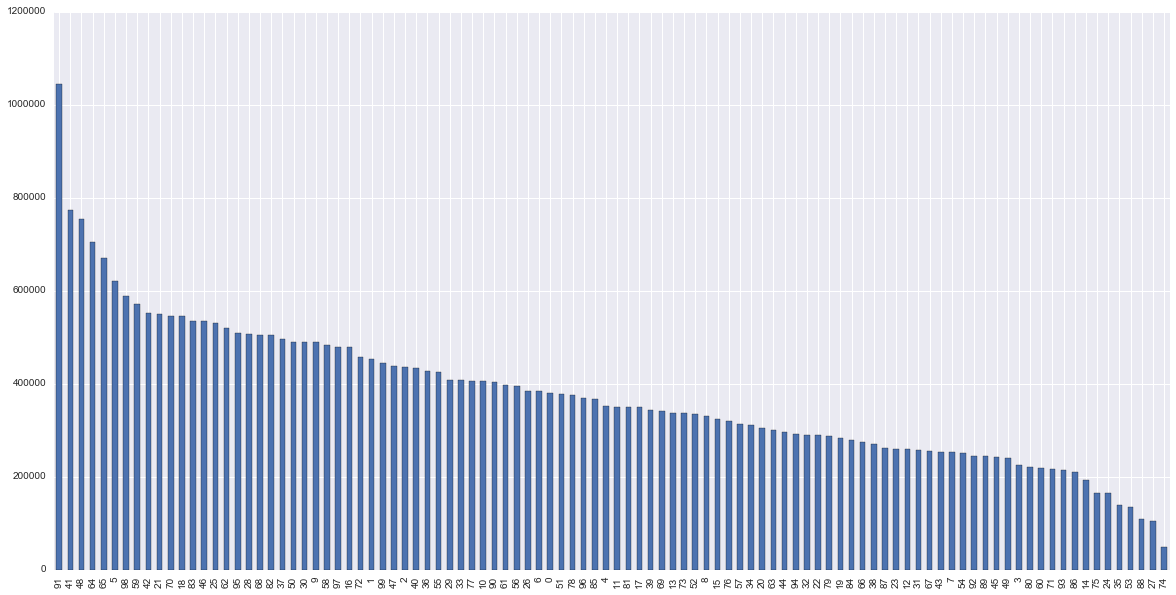

In [3]:
fig, ax = plt.subplots()
hotels_info_sorted = hotels_info.sort_values(ascending=False)
hotels_info_sorted.plot(kind="bar", figsize=(20,10))

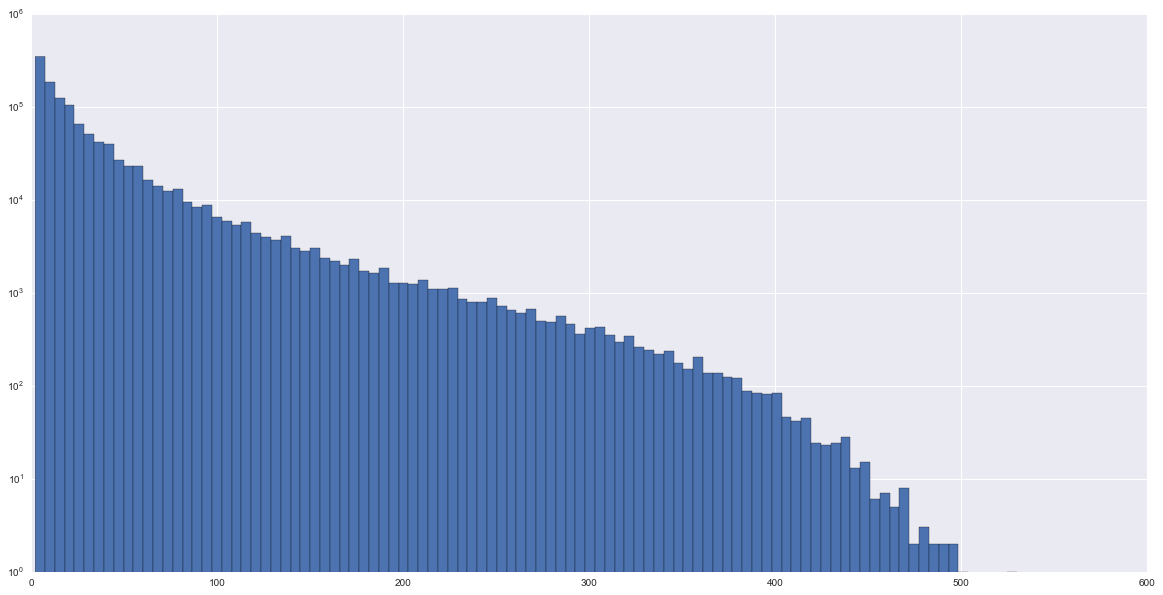

In [4]:
fig, ax = plt.subplots()
users_info.hist(ax=ax, bins=100, figsize=(20,10))
ax.set_yscale('log')

In [ ]:
[(0, 'id'),
 (1, 'date_time'),
 (2, 'site_name'),
 (3, 'posa_continent'),
 (4, 'user_location_country'),
 (5, 'user_location_region'),
 (6, 'user_location_city'),
 (7, 'orig_destination_distance'),
 (8, 'user_id'),
 (9, 'is_mobile'),
 (10, 'is_package'),
 (11, 'channel'),
 (12, 'srch_ci'),
 (13, 'srch_co'),
 (14, 'srch_adults_cnt'),
 (15, 'srch_children_cnt'),
 (16, 'srch_rm_cnt'),
 (17, 'srch_destination_id'),
 (18, 'srch_destination_type_id'),
 (19, 'hotel_continent'),
 (20, 'hotel_country'),
 (21, 'hotel_market')]


def write_result(filename='submission.csv'):
    with open(filename, 'w') as outfile:
        outfile.write('id,hotel_cluster\n')
        with open('test.csv', 'rb') as f:
            csv_reader = csv.reader(f)
            csv_reader.next()  # skip header
            for i, row in enumerate(csv_reader):
                # todo: put here real data
                outfile.write('%s,%s\n' % (row[0], 0)
